This file implements all the variants of flow matching algorithms proposed in the "Temporal Difference Flows" paper by Farebrother et al.

As a next to-do, we plan to implement the diffusion-based successor modeling.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

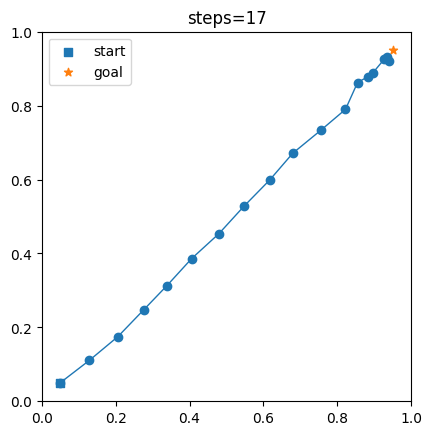

In [2]:
# Define an environment and a policy

# -----------------------------
# Environment
# -----------------------------
class ContinuousGrid2D:
    def __init__(self, 
                 bounds=((0.0, 1.0), (0.0, 1.0)),
                 start=(0.05, 0.05),
                 goal=(0.95, 0.95),
                 dt=0.05,
                 goal_radius=0.03,
                 a_max=1.0,
                 max_steps=500):
        self.xmin, self.xmax = bounds[0]
        self.ymin, self.ymax = bounds[1]
        self.start = np.array(start, dtype=np.float32)
        self.goal = np.array(goal, dtype=np.float32)
        self.dt = float(dt)
        self.goal_radius = float(goal_radius)
        self.a_max = float(a_max)
        self.max_steps = int(max_steps)
        self.reset()

    def reset(self):
        self.state = self.start.copy()
        self.steps = 0
        return self.state.copy()
    
    def reset_to_state(self, state):
        self.state = state
        self.steps = 0
        return self.state.copy()

    def step(self, action):
        action = np.asarray(action, dtype=np.float32)
        # clip action norm
        norm = np.linalg.norm(action)
        if norm > self.a_max:
            action = (action / (norm + 1e-8)) * self.a_max
        # integrate
        next_state = self.state + self.dt * action
        # clamp to bounds
        next_state[0] = np.clip(next_state[0], self.xmin, self.xmax)
        next_state[1] = np.clip(next_state[1], self.ymin, self.ymax)
        self.state = next_state
        self.steps += 1
        # termination
        dist = np.linalg.norm(self.state - self.goal)
        done = (dist <= self.goal_radius) or (self.steps >= self.max_steps)
        # reward: negative distance until absorption, then 0
        reward = 0.0 if dist <= self.goal_radius else -dist
        info = {"dist_to_goal": dist}
        return self.state.copy(), float(reward), done, info

# -----------------------------
# Stochastic Goal-Seeking Policy
# -----------------------------
class StochasticProportionalPolicy:
    def __init__(self, k=2.0, noise_std=0.1, a_max=1.0):
        self.k = float(k)
        self.noise_std = float(noise_std)
        self.a_max = float(a_max)

    def act(self, state, goal):
        state = np.asarray(state, dtype=np.float32)
        goal = np.asarray(goal, dtype=np.float32)
        direction = goal - state
        action = self.k * direction
        norm = np.linalg.norm(action)
        if norm > self.a_max:
            action = (action / (norm + 1e-8)) * self.a_max
        action = action + np.random.normal(0.0, self.noise_std, size=2).astype(np.float32)
        norm = np.linalg.norm(action)
        if norm > self.a_max:
            action = (action / (norm + 1e-8)) * self.a_max
        return action.astype(np.float32)

# %%
env = ContinuousGrid2D(dt=0.1)
policy = StochasticProportionalPolicy(k=3.0, noise_std=.1, a_max=1.0)

# Visualize the policy
states = [env.reset()]
for _ in range(env.max_steps):
    a = policy.act(states[-1], env.goal)
    s, r, done, _ = env.step(a)
    states.append(s)
    if done: break
states = np.array(states, dtype=np.float32)
plt.figure()
plt.plot(states[:,0], states[:,1], marker='o', linewidth=1)
plt.scatter([env.start[0]],[env.start[1]], marker='s', label='start')
plt.scatter([env.goal[0]],[env.goal[1]], marker='*', label='goal')
plt.gca().set_aspect('equal', 'box')
plt.xlim(env.xmin, env.xmax); plt.ylim(env.ymin, env.ymax)
plt.title(f"steps={len(states)-1}")
plt.legend(); plt.show()

In [3]:
# Gather offline dataset
from tqdm import tqdm
NUM_TRANSITIONS_TO_SAMPLE = int(1e5)

offline_dataset = {
    "states": [],
    "actions": [],
    "next_states": [],
    "rewards": [],
    "dones": []
}
state = env.reset()
for i in tqdm(range(NUM_TRANSITIONS_TO_SAMPLE)):
    action = policy.act(state, env.goal)
    next_state, reward, done, info = env.step(action)
    offline_dataset["states"].append(state)
    offline_dataset["actions"].append(action)
    offline_dataset["rewards"].append(reward)
    offline_dataset["next_states"].append(next_state)
    offline_dataset["dones"].append(done)
    
    state = next_state
    if done: 
        state = env.reset()
    
# Convert the lists in the offline datset to numpy arrays
offline_dataset["states"] = np.array(offline_dataset["states"])
offline_dataset["actions"] = np.array(offline_dataset["actions"])
offline_dataset["rewards"] = np.array(offline_dataset["rewards"])
offline_dataset["next_states"] = np.array(offline_dataset["next_states"])
offline_dataset["dones"] = np.array(offline_dataset["dones"])


100%|██████████| 100000/100000 [00:04<00:00, 24038.44it/s]


In [4]:
offline_dataset["states"][4:10]

array([[0.30164894, 0.34014666],
       [0.3605097 , 0.40246734],
       [0.42729324, 0.46617335],
       [0.48446566, 0.54821795],
       [0.56195927, 0.60050684],
       [0.61965   , 0.67794514]], dtype=float32)

In [5]:
GAMMA = .9

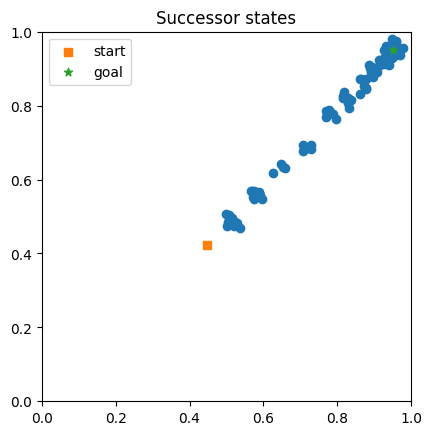

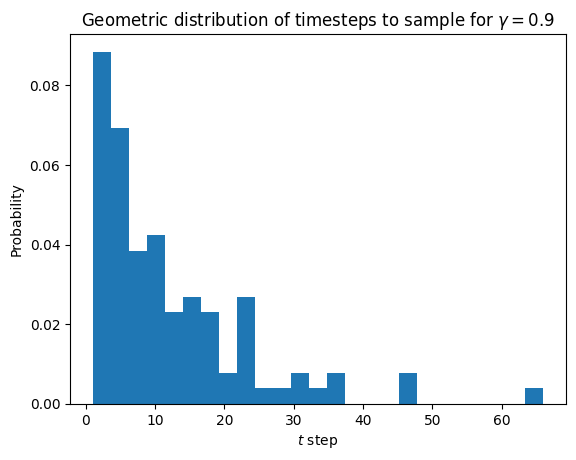

In [6]:
# Gather successor model for a provided (state, action) pair

def plot_timestep_distribution(timesteps):
    plt.figure()
    plt.hist(timesteps, density=True, bins=25)
    plt.title(f"Geometric distribution of timesteps to sample for $\\gamma={GAMMA}$")
    plt.xlabel("$t$ step")
    plt.ylabel("Probability")
    plt.show()

def gather_successor_model(env, policy, state, action, gamma, num_samples):
    
    sampled_successor_states = []
    sampled_timesteps = []
    
    orig_state = state.copy()
    for _ in range(num_samples):
        env.reset_to_state(orig_state)
        
        # Sample from geometric distribution
        timestep_to_sample = np.random.geometric(p=(1-gamma))
        
        # Take the first step
        action = policy.act(env.state, env.goal)
        next_state, reward, done, info = env.step(action)
        
        for _ in range(timestep_to_sample - 1):
            state = next_state
            action = policy.act(env.state, env.goal)
            next_state, reward, done, info = env.step(action)
        
        sampled_successor_states.append(next_state)
        sampled_timesteps.append(timestep_to_sample)

    return np.array(sampled_successor_states, dtype=np.float32), np.array(sampled_timesteps, dtype=np.int32)

# Successor states
def plot_successor_states(env, sampled_successor_states, state):
    plt.figure()
    plt.scatter(sampled_successor_states[:,0], sampled_successor_states[:,1], marker='o', linewidth=1)
    plt.scatter([state[0]],[state[1]], marker='s', label='start')
    plt.scatter([env.goal[0]],[env.goal[1]], marker='*', label='goal')
    plt.gca().set_aspect('equal', 'box')
    plt.xlim(env.xmin, env.xmax)
    plt.ylim(env.ymin, env.ymax)
    plt.title(f"Successor states")
    plt.legend() 
    plt.show()


sampled_successor_states, sampled_timesteps = gather_successor_model(env, policy, state, action, GAMMA, 100)
plot_successor_states(env, sampled_successor_states, state)
plot_timestep_distribution(sampled_timesteps)

In [7]:
# Define a flow matching model

class FlowMatchingModel(nn.Module):
    def __init__(self, state_dim: int = 2, action_dim: int = 2, h: int = 64):
        super().__init__()
        # Input: t (1) + state (state_dim) + action (action_dim) + x_t (state_dim)
        input_dim = 1 + state_dim + action_dim + state_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, state_dim))
        
    def forward(self, t, state, action, x_t):
        """
        t: time [batch_size, 1]
        state: conditioning state [batch_size, state_dim]
        action: conditioning action [batch_size, action_dim]
        x_t: current position [batch_size, state_dim]
        """
        return self.net(torch.cat((t, state, action, x_t), -1))
    
    def step(self, x_t, t_start, t_end, state, action):
        """Midpoint integration step (RK2)"""
        # Reshape t_start to match batch size
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        dt = t_end - t_start
        
        # Step 1: Evaluate velocity at the start
        v_start = self(t=t_start, state=state, action=action, x_t=x_t)
        
        # Step 2: Compute midpoint position and time
        x_mid = x_t + (dt / 2) * v_start
        t_mid = t_start + dt / 2
        
        # Step 3: Evaluate velocity at the midpoint
        v_mid = self(t=t_mid, state=state, action=action, x_t=x_mid)
        
        # Step 4: Take full step using midpoint velocity
        return x_t + dt * v_mid
    

In [8]:
flow_model = FlowMatchingModel(state_dim=2, action_dim=2, h=64)

# single time step 
t = torch.Tensor([1])
state = torch.Tensor(offline_dataset['states'][0])
action = torch.Tensor(offline_dataset['actions'][0])
print(flow_model(t, state, action, state))

# batch
t = torch.arange(10).view(-1, 1)
state = torch.Tensor([offline_dataset['states'][0]]*10)
action = torch.Tensor([offline_dataset['actions'][0]]*10)
print(flow_model(t, state, action, state))

tensor([0.1931, 0.0669], grad_fn=<ViewBackward0>)
tensor([[ 0.1918,  0.1043],
        [ 0.1931,  0.0669],
        [ 0.1852,  0.0315],
        [ 0.1730, -0.0035],
        [ 0.1589, -0.0383],
        [ 0.1441, -0.0734],
        [ 0.1289, -0.1092],
        [ 0.1138, -0.1456],
        [ 0.0987, -0.1826],
        [ 0.0836, -0.2199]], grad_fn=<AddmmBackward0>)


/tmp/ipykernel_1909048/3294715624.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  state = torch.Tensor([offline_dataset['states'][0]]*10)


# MC-CFM

In [9]:
mccfm_flow_model = FlowMatchingModel(state_dim=2, action_dim=2, h=64)

In [10]:
def sample_x1_mc_cfm(env, policy, flow_model, state, action, next_state, gamma):
    
    # Sample from geometric distribution
    timestep_to_sample = np.random.geometric(p=(1-gamma))
    
    if timestep_to_sample == 1:
        return np.array(next_state)

    else:
        env.reset_to_state(np.array(next_state))
        for _ in range(timestep_to_sample - 1): # For remaining timesteps, keep acting
            action = policy.act(env.state, env.goal)
            next_state, reward, done, info = env.step(action)
            if done:
                break

        return np.array(next_state)
        

In [11]:
# Test the sample function
random_transition_idx = np.random.choice(NUM_TRANSITIONS_TO_SAMPLE)
print(offline_dataset["states"][random_transition_idx], offline_dataset["actions"][random_transition_idx], offline_dataset["next_states"][random_transition_idx])

sample_x1_mc_cfm(env, policy, mccfm_flow_model, offline_dataset["states"][random_transition_idx], offline_dataset["actions"][random_transition_idx], offline_dataset["next_states"][random_transition_idx], GAMMA)

[0.48651198 0.44315034] [0.6685564 0.695431 ] [0.5533676  0.51269346]


array([0.974347 , 0.9377671], dtype=float32)

In [12]:
# Training the flow model to predict x1's sampled from ground truth MC-successor model

# sample t from uniform 0, 1
# sample a (state,action) from the offline data and a corresponding successor state x_1
# sample x_t from normal distribution conditioned on the z = x_1
# 

NUM_ITERATIONS = 500
BATCH_SIZE = 256

optimizer = torch.optim.Adam(lr=1e-3, params=mccfm_flow_model.parameters())

for train_iter in range(NUM_ITERATIONS):
    
    # Gather the indices of BATCH_SIZE
    batch_indices = np.random.choice(NUM_TRANSITIONS_TO_SAMPLE, size=(BATCH_SIZE,))
    
    # Gather the batch data
    batch_states = torch.Tensor(offline_dataset["states"][batch_indices])
    batch_actions = torch.Tensor(offline_dataset["actions"][batch_indices])
    batch_next_states = torch.Tensor(offline_dataset["next_states"][batch_indices])
    
    # clear the compute graph
    optimizer.zero_grad()
    loss = 0.0 
    
    # sample time
    t = torch.rand(size=(BATCH_SIZE, 1))
    
    # sample mc successor states 
    x_1s = []
    x_ts = [] # The position in the flow where we want to get the vector field
    for idx in range(BATCH_SIZE):
        x_1 = sample_x1_mc_cfm(env, policy, mccfm_flow_model, batch_states[idx], batch_actions[idx], batch_next_states[idx], GAMMA)
        mean = t[idx][0]*x_1
        cov = ((1-t[idx])**2)*np.eye(x_1.shape[0])
        
        x_1s.append(x_1)
        x_ts.append(np.random.multivariate_normal(mean, cov))
    
    x_1s = torch.Tensor(x_1s)
    x_ts = torch.Tensor(x_ts)
    
    # Groundtruth velocities
    u_t_1s = torch.Tensor((x_1s - x_ts)/(1 - t))

    # Flow model velocities
    flow_model_velocity = mccfm_flow_model(t = t, state = batch_states, action = batch_actions, x_t = x_ts)
    
    loss = torch.linalg.norm(u_t_1s - flow_model_velocity, axis=1).pow(2).mean()
    loss.backward()
    optimizer.step()
    print(f"Train Iter {train_iter}, Loss: {loss.item()}")
    
    

/tmp/ipykernel_1909048/1461848605.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  env.reset_to_state(np.array(next_state))
/tmp/ipykernel_1909048/2518119120.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mean = t[idx][0]*x_1
/tmp/ipykernel_1909048/2518119120.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cov = ((1-t[idx])**2)*np.eye(x_1.shape[0])
/tmp/ipykernel_1909048/2518119120.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy

Train Iter 0, Loss: 3.342759847640991
Train Iter 1, Loss: 3.194676399230957
Train Iter 2, Loss: 3.2067129611968994
Train Iter 3, Loss: 2.739643096923828
Train Iter 4, Loss: 2.599339246749878
Train Iter 5, Loss: 2.4280028343200684
Train Iter 6, Loss: 2.4989635944366455
Train Iter 7, Loss: 2.1342525482177734
Train Iter 8, Loss: 2.0084152221679688
Train Iter 9, Loss: 1.9568661451339722
Train Iter 10, Loss: 1.928868055343628
Train Iter 11, Loss: 1.6977171897888184
Train Iter 12, Loss: 1.7543108463287354
Train Iter 13, Loss: 1.5958048105239868
Train Iter 14, Loss: 1.8247872591018677
Train Iter 15, Loss: 1.5494182109832764
Train Iter 16, Loss: 1.654710054397583
Train Iter 17, Loss: 1.5822373628616333
Train Iter 18, Loss: 1.6370670795440674
Train Iter 19, Loss: 1.5303776264190674
Train Iter 20, Loss: 1.5301706790924072
Train Iter 21, Loss: 1.3730649948120117
Train Iter 22, Loss: 1.362189769744873
Train Iter 23, Loss: 1.2366065979003906
Train Iter 24, Loss: 1.2382732629776
Train Iter 25, Loss:

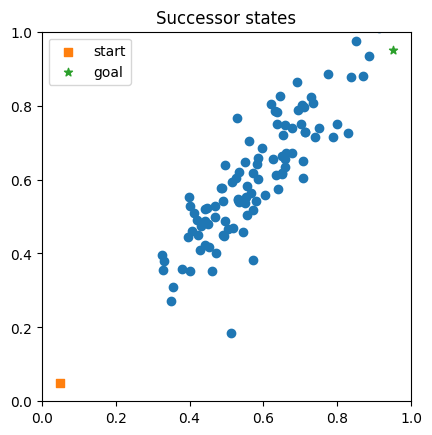

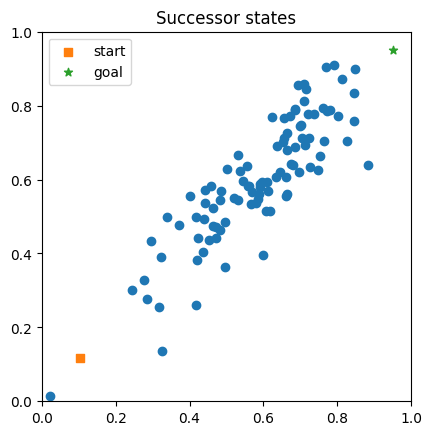

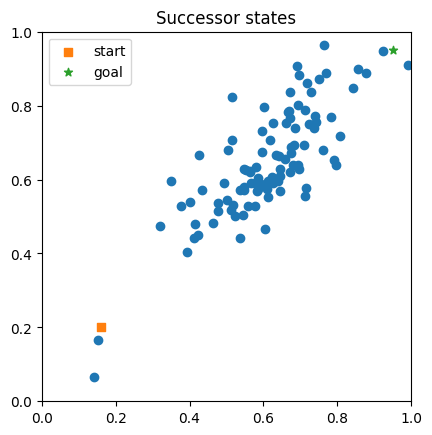

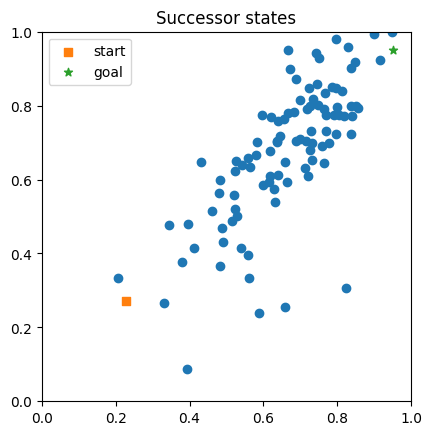

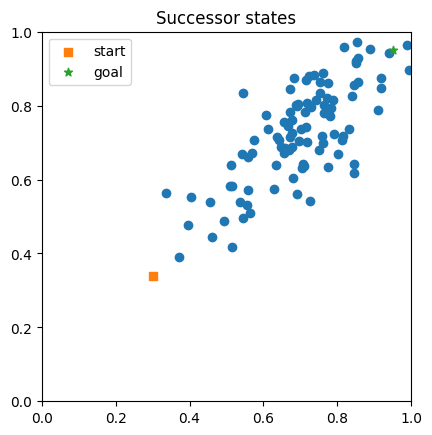

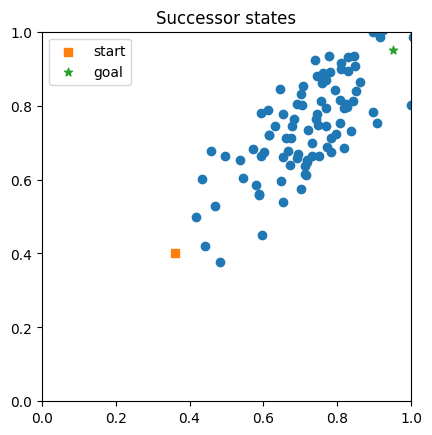

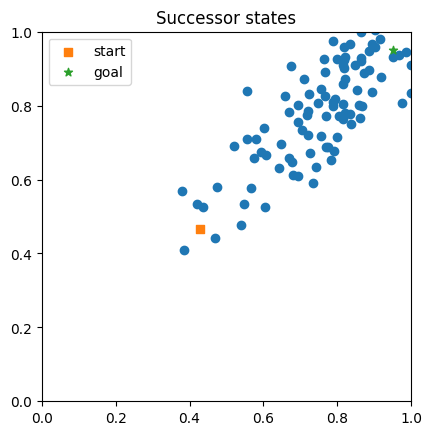

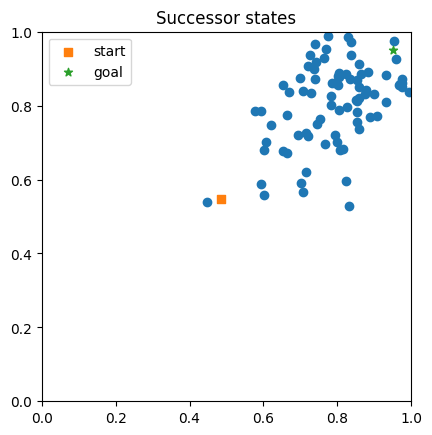

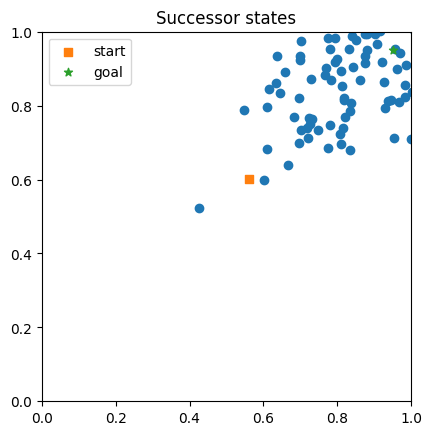

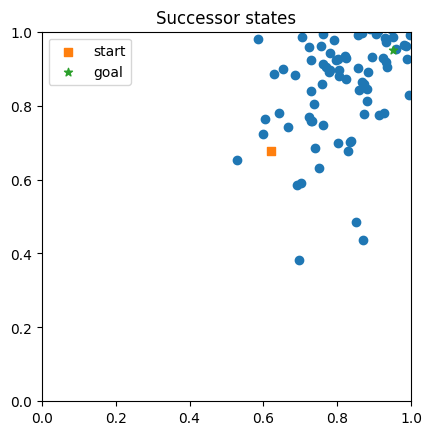

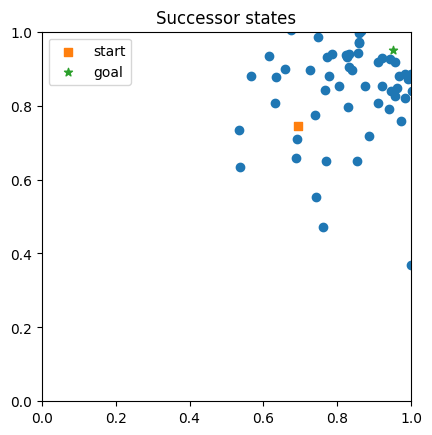

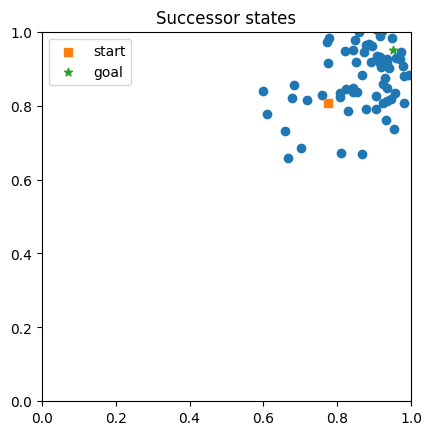

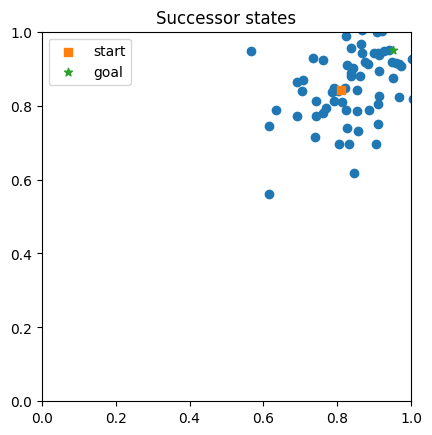

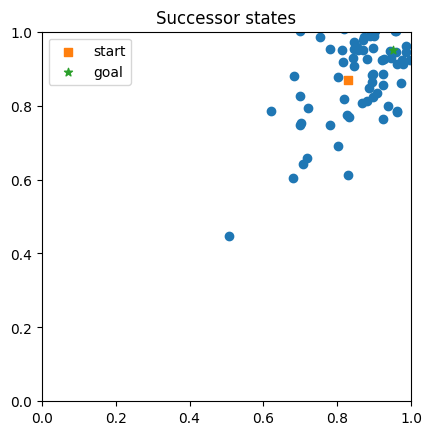

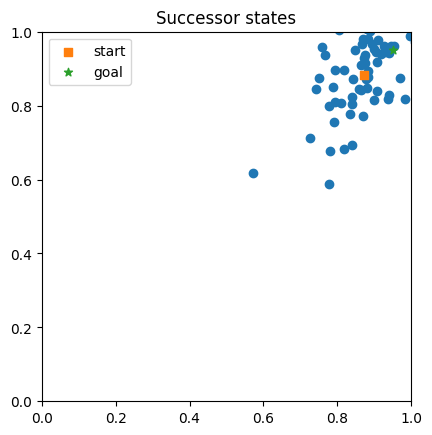

In [13]:
# Visualize the learnt flow model
NUM_INTEGRATION_STEPS = 10

def gather_flow_based_successor_states(flow_model, state, action, num_states = 100):
    
    # sample random noise from N(0, I)
    x_t = np.random.multivariate_normal(mean=np.zeros_like(state), cov = np.eye(N=np.shape(state)[0]), size=(num_states, )) # NOTE: this is x_0.
    x_t = torch.Tensor(x_t)
    time_steps = torch.linspace(0, 1.0, NUM_INTEGRATION_STEPS + 1)
    
    with torch.no_grad():
        for j in range(NUM_INTEGRATION_STEPS):
            x_t = flow_model.step(
                        x_t=x_t,
                        t_start=time_steps[j],
                        t_end=time_steps[j + 1],
                        state = torch.Tensor([state]*num_states),
                        action = torch.Tensor([action]*num_states)
                        )
    
    return x_t


for time_step in range(15):
    time_step_to_plot= time_step
    state = offline_dataset["states"][time_step_to_plot]
    action = offline_dataset["actions"][time_step_to_plot]
    flow_model_successor_states = gather_flow_based_successor_states(mccfm_flow_model, state, action, num_states = 100)
    plot_successor_states(env, flow_model_successor_states, state)

## TD-CFM

In [14]:
tdcfm_flow_model = FlowMatchingModel(state_dim=2, action_dim=2, h=64)

In [15]:
# Train the flow matching model on offline dataset using TD-CFM

def sample_x1_tdcfm(env, policy, flow_model, state, action, next_state, gamma):
    
    # with prob 1 - gamma choose next_state 
    if np.random.rand() < 1 - gamma:
        return np.array(next_state)
        
    else:
        # Sample by integrating flow_model
        x_t = np.random.multivariate_normal(mean=np.zeros_like(state), cov = np.eye(N=np.shape(state)[0])) # Forms the start point to integrate the noise
        x_t = torch.Tensor(x_t).view(1, -1) # BS, state_dim
        time_steps = torch.linspace(0, 1.0, NUM_INTEGRATION_STEPS + 1)
        
        next_action = policy.act(next_state, env.goal)
        
        with torch.no_grad():
            for j in range(NUM_INTEGRATION_STEPS):
                x_t = flow_model.step(
                            x_t=x_t,
                            t_start=time_steps[j],
                            t_end=time_steps[j + 1],
                            state = next_state.view(1, -1),
                            action = torch.Tensor([next_action])
                            )
    
        return np.array(x_t[0])

print(sample_x1_tdcfm(env, policy, tdcfm_flow_model, state, action, torch.Tensor(next_state), GAMMA))

[1.7761967 0.4574691]


/tmp/ipykernel_1909048/3793424845.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x_t[0])


In [16]:
# Training the flow model to predict x1's bootstrapped from the flow model

# sample t from uniform 0, 1
# sample a (state,action) from the offline data and a corresponding successor state x_1
# sample x_t from normal distribution conditioned on the z = x_1
# 

NUM_ITERATIONS = 200
BATCH_SIZE = 256

optimizer = torch.optim.Adam(lr=1e-3, params=tdcfm_flow_model.parameters())

for train_iter in range(NUM_ITERATIONS):
    
    # Gather the indices of BATCH_SIZE
    batch_indices = np.random.choice(NUM_TRANSITIONS_TO_SAMPLE, size=(BATCH_SIZE,))
    
    # Gather the batch data
    batch_states = torch.Tensor(offline_dataset["states"][batch_indices])
    batch_actions = torch.Tensor(offline_dataset["actions"][batch_indices])
    batch_next_states = torch.Tensor(offline_dataset["next_states"][batch_indices])
    
    # clear the compute graph
    optimizer.zero_grad()
    loss = 0.0 
    
    # sample time
    t = torch.rand(size=(BATCH_SIZE, 1))
    
    # sample mc successor states 
    x_1s = []
    x_ts = [] # The position in the flow where we want to get the vector field
    for idx in range(BATCH_SIZE):
        x_1 = sample_x1_tdcfm(env, policy, tdcfm_flow_model, batch_states[idx], batch_actions[idx], batch_next_states[idx], GAMMA)
        mean = t[idx][0]*x_1
        cov = ((1-t[idx])**2)*np.eye(x_1.shape[0])
        
        x_1s.append(x_1)
        x_ts.append(np.random.multivariate_normal(mean, cov))
    
    x_1s = torch.Tensor(x_1s)
    x_ts = torch.Tensor(x_ts)
    
    # Groundtruth velocities
    u_t_1s = torch.Tensor((x_1s - x_ts)/(1 - t))

    # Flow model velocities
    flow_model_velocity = tdcfm_flow_model(t = t, state = batch_states, action = batch_actions, x_t = x_ts)
    
    loss = torch.linalg.norm(u_t_1s - flow_model_velocity, axis=1).pow(2).mean()
    loss.backward()
    optimizer.step()
    print(f"Train Iter {train_iter}, Loss: {loss.item()}")
    
    

/tmp/ipykernel_1909048/3793424845.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(next_state)
/tmp/ipykernel_1909048/931867997.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mean = t[idx][0]*x_1
/tmp/ipykernel_1909048/931867997.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cov = ((1-t[idx])**2)*np.eye(x_1.shape[0])
/tmp/ipykernel_1909048/931867997.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword argumen

Train Iter 0, Loss: 3.1181113719940186


Train Iter 1, Loss: 3.9100723266601562
Train Iter 2, Loss: 3.9065322875976562
Train Iter 3, Loss: 3.6192283630371094
Train Iter 4, Loss: 3.645966053009033
Train Iter 5, Loss: 3.1548125743865967
Train Iter 6, Loss: 3.2477025985717773
Train Iter 7, Loss: 3.878620147705078
Train Iter 8, Loss: 3.6164097785949707
Train Iter 9, Loss: 2.8457789421081543
Train Iter 10, Loss: 3.5890488624572754
Train Iter 11, Loss: 3.2093052864074707
Train Iter 12, Loss: 3.293527364730835
Train Iter 13, Loss: 2.970033884048462
Train Iter 14, Loss: 2.834174394607544
Train Iter 15, Loss: 2.986294746398926
Train Iter 16, Loss: 3.165156841278076
Train Iter 17, Loss: 2.702146530151367
Train Iter 18, Loss: 2.437863826751709
Train Iter 19, Loss: 2.563572645187378
Train Iter 20, Loss: 2.7542531490325928
Train Iter 21, Loss: 2.5248117446899414
Train Iter 22, Loss: 2.4223101139068604
Train Iter 23, Loss: 2.632479429244995
Train Iter 24, Loss: 2.5184385776519775
Train Iter 25, Loss: 1.9486653804779053
Train Iter 26, Loss:

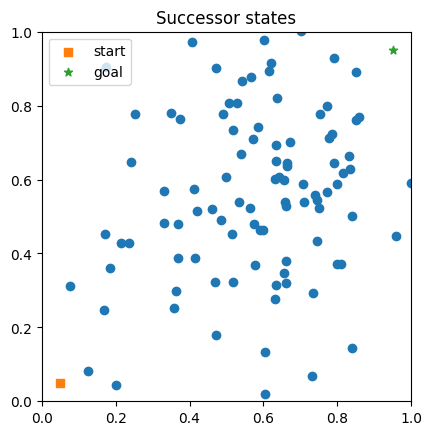

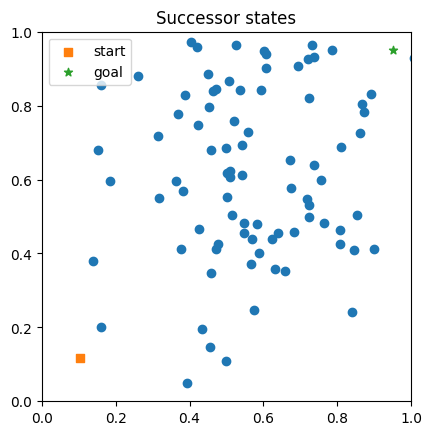

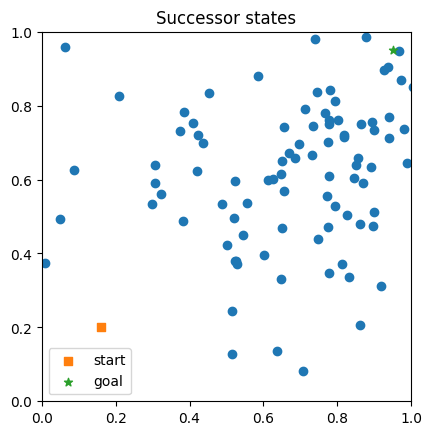

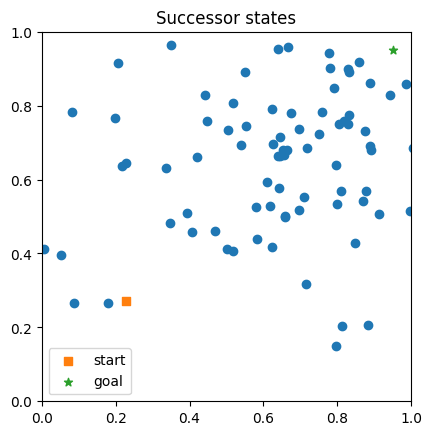

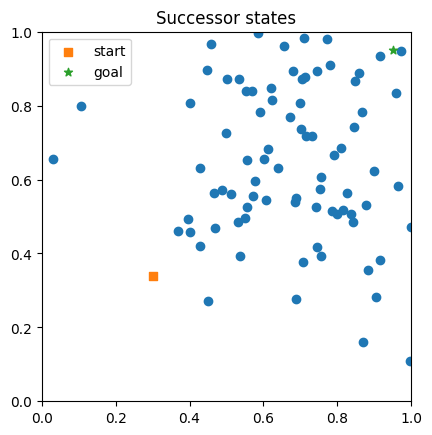

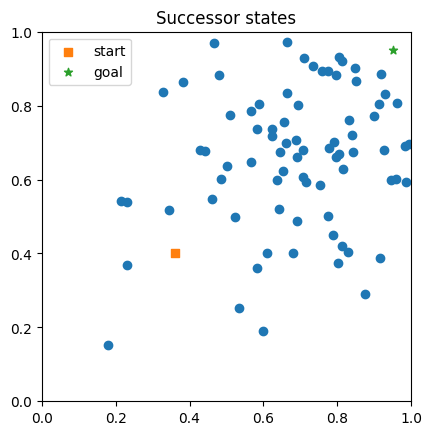

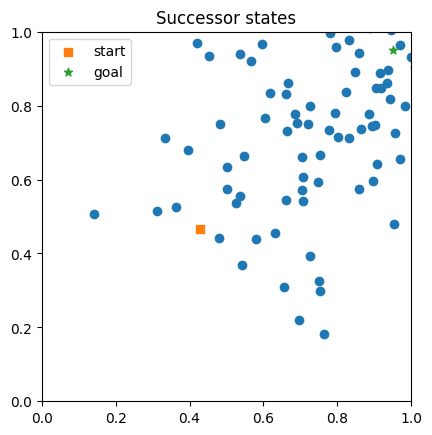

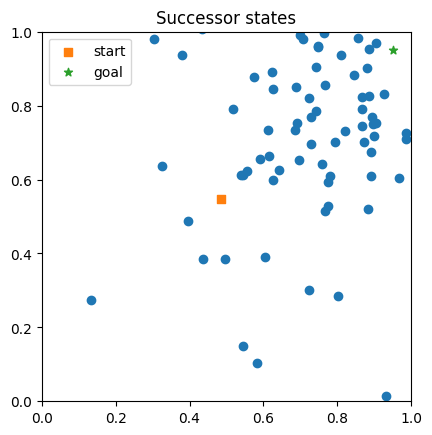

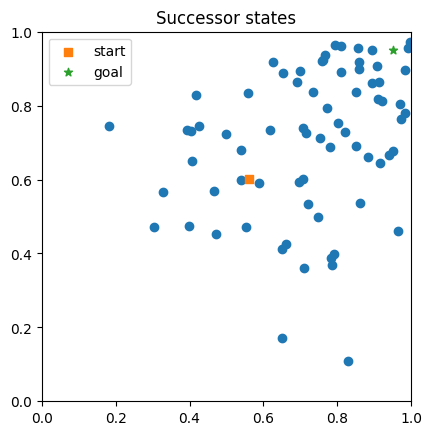

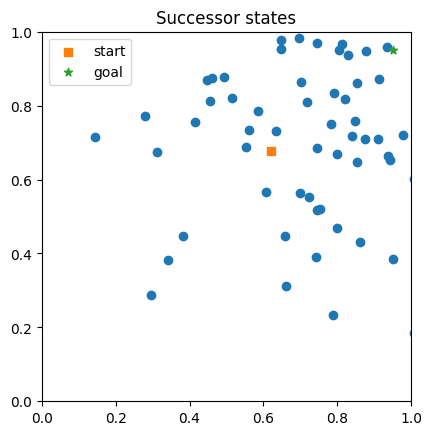

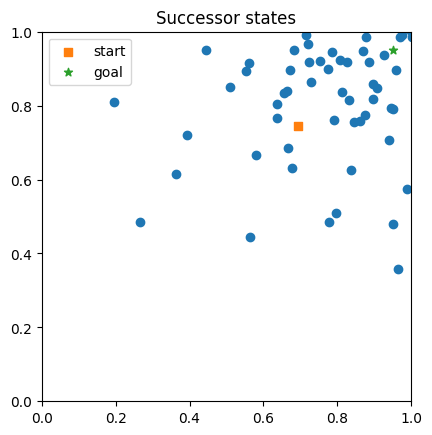

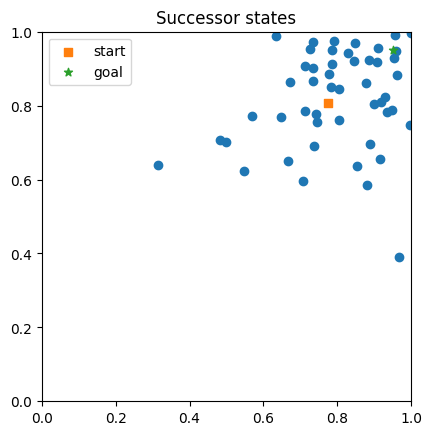

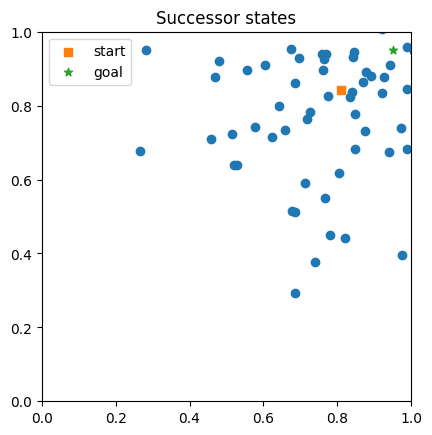

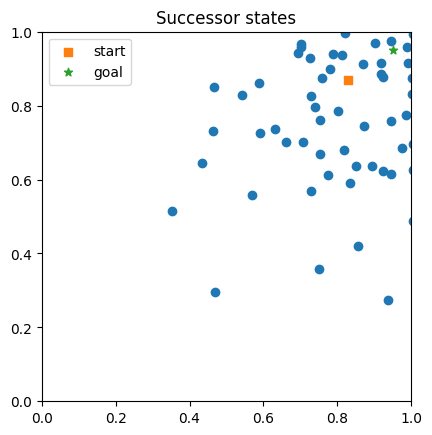

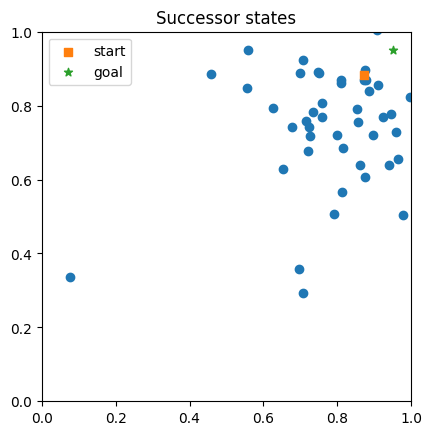

In [17]:
# Visualize the learnt flow model
NUM_INTEGRATION_STEPS = 10

def gather_flow_based_successor_states(flow_model, state, action, num_states = 100):
    
    # sample random noise from N(0, I)
    x_t = np.random.multivariate_normal(mean=np.zeros_like(state), cov = np.eye(N=np.shape(state)[0]), size=(num_states, )) # NOTE: this is x_0.
    x_t = torch.Tensor(x_t)
    time_steps = torch.linspace(0, 1.0, NUM_INTEGRATION_STEPS + 1)
    
    with torch.no_grad():
        for j in range(NUM_INTEGRATION_STEPS):
            x_t = flow_model.step(
                        x_t=x_t,
                        t_start=time_steps[j],
                        t_end=time_steps[j + 1],
                        state = torch.Tensor([state]*num_states),
                        action = torch.Tensor([action]*num_states)
                        )
    
    return x_t


for time_step in range(15):
    time_step_to_plot= time_step
    state = offline_dataset["states"][time_step_to_plot]
    action = offline_dataset["actions"][time_step_to_plot]
    flow_model_successor_states = gather_flow_based_successor_states(tdcfm_flow_model, state, action, num_states = 100)
    plot_successor_states(env, flow_model_successor_states, state)

## Coupled TD-CFM

In [18]:
tdcfmc_flow_model = FlowMatchingModel(state_dim=2, action_dim=2, h=64)

In [19]:
# Training the flow model to predict x1's bootstrapped from the flow model. x_t is defined using coupling, which changes the p_t|z distribution used to sample the t'th point.

# sample t from uniform 0, 1
# sample a (state,action) from the offline data and a corresponding successor state x_1
# sample x_t from normal distribution conditioned on the z = x_1
# 

NUM_ITERATIONS = 200
BATCH_SIZE = 256

optimizer = torch.optim.Adam(lr=1e-3, params=tdcfmc_flow_model.parameters())

for train_iter in range(NUM_ITERATIONS):
    
    # Gather the indices of BATCH_SIZE
    batch_indices = np.random.choice(NUM_TRANSITIONS_TO_SAMPLE, size=(BATCH_SIZE,))
    
    # Gather the batch data
    batch_states = torch.Tensor(offline_dataset["states"][batch_indices])
    batch_actions = torch.Tensor(offline_dataset["actions"][batch_indices])
    batch_next_states = torch.Tensor(offline_dataset["next_states"][batch_indices])
    
    # clear the compute graph
    optimizer.zero_grad()
    loss = 0.0 
    
    # sample time
    t = torch.rand(size=(BATCH_SIZE, 1))
    x_0s = np.random.multivariate_normal(mean = np.zeros((2)), cov=np.eye(2), size=(BATCH_SIZE,))
    
    # sample mc successor states 
    x_1s = []
    x_ts = [] # The position in the flow where we want to get the vector field
    for idx in range(BATCH_SIZE):
        x_1 = sample_x1_tdcfm(env, policy, tdcfmc_flow_model, batch_states[idx], batch_actions[idx], batch_next_states[idx], GAMMA)
        x_1s.append(np.array(x_1))
        x_ts.append(np.array(t[idx]*x_1 + (1-t[idx])*x_0s[idx])) # NOTE this is TD-CFM (C) specific coupling between the sampled noise and the data to match
        
    x_1s = np.array(x_1s)
    x_ts = np.array(x_ts)
    
    x_1s = torch.Tensor(x_1s)
    x_ts = torch.Tensor(x_ts)
    
    # Groundtruth velocities
    u_t_0_1s = torch.Tensor((x_1s - x_0s)) # NOTE the change here

    # Flow model velocities
    flow_model_velocity = tdcfmc_flow_model(t = t, state = batch_states, action = batch_actions, x_t = x_ts)
    
    loss = torch.linalg.norm(u_t_0_1s - flow_model_velocity, axis=1).pow(2).mean()
    loss.backward()
    optimizer.step()
    print(f"Train Iter {train_iter}, Loss: {loss.item()}")
    
    

/tmp/ipykernel_1909048/3793424845.py:27: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x_t[0])
/tmp/ipykernel_1909048/1026221423.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_ts.append(np.array(t[idx]*x_1 + (1-t[idx])*x_0s[idx])) # NOTE this is TD-CFM (C) specific coupling between the sampled noise and the data to match
/tmp/ipykernel_1909048/1026221423.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide

/tmp/ipykernel_1909048/1026221423.py:46: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  u_t_0_1s = torch.Tensor((x_1s - x_0s)) # NOTE the change here


Train Iter 0, Loss: 3.940600451032304
Train Iter 1, Loss: 3.6695445609935122
Train Iter 2, Loss: 3.6162752393638575
Train Iter 3, Loss: 3.9073933258082656
Train Iter 4, Loss: 3.6898174914987223
Train Iter 5, Loss: 3.5536928253949824
Train Iter 6, Loss: 3.5521662628882718
Train Iter 7, Loss: 3.1965499986789387
Train Iter 8, Loss: 3.871916111405459
Train Iter 9, Loss: 4.051552795338495
Train Iter 10, Loss: 3.540032084730295
Train Iter 11, Loss: 3.5829788516088197
Train Iter 12, Loss: 3.489038597079605
Train Iter 13, Loss: 3.7765926319609404
Train Iter 14, Loss: 3.232756502634216
Train Iter 15, Loss: 3.167273586738933
Train Iter 16, Loss: 3.2214705609893666
Train Iter 17, Loss: 3.060331781369869
Train Iter 18, Loss: 3.4671107125172784
Train Iter 19, Loss: 3.5722969510244336
Train Iter 20, Loss: 3.2686188408935117
Train Iter 21, Loss: 3.2066110832659156
Train Iter 22, Loss: 3.0058126967048096
Train Iter 23, Loss: 3.085464753509488
Train Iter 24, Loss: 3.1932118703929144
Train Iter 25, Loss

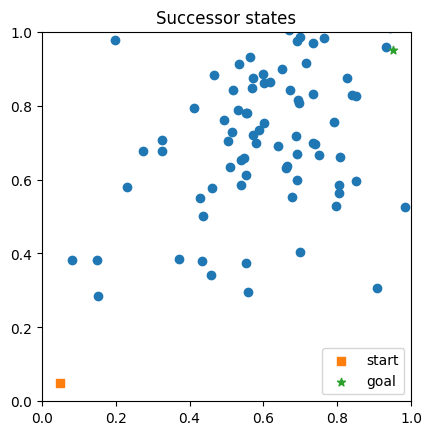

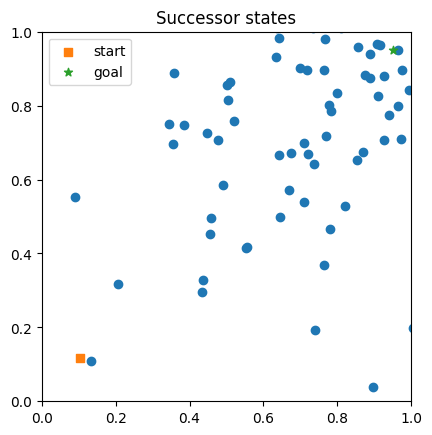

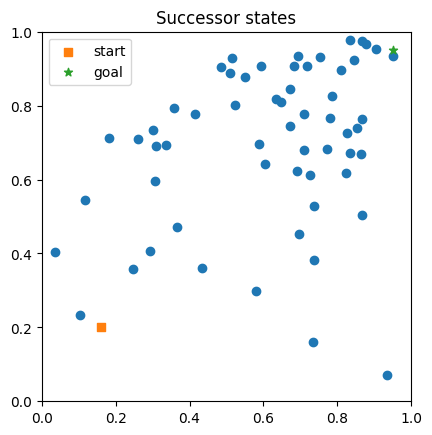

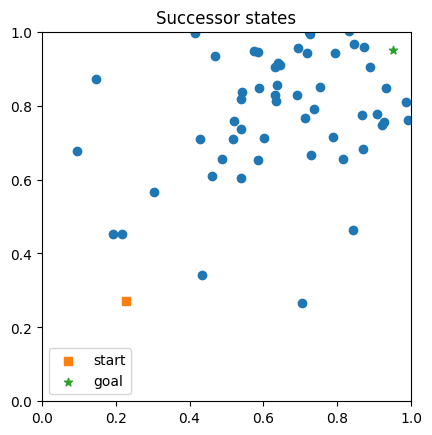

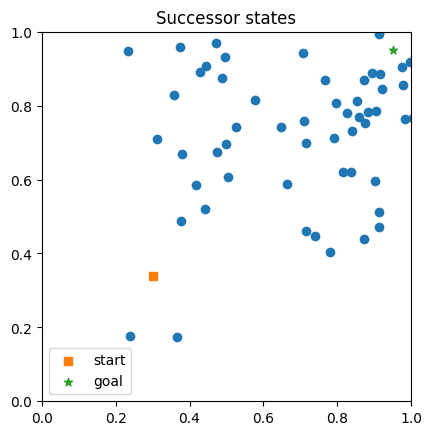

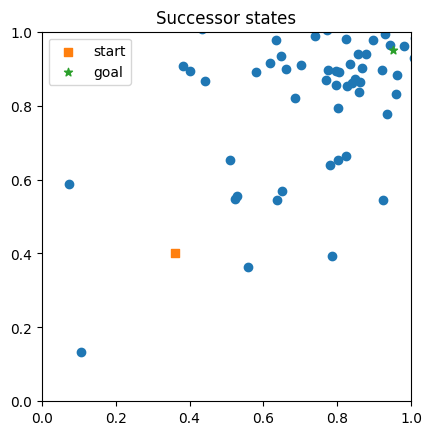

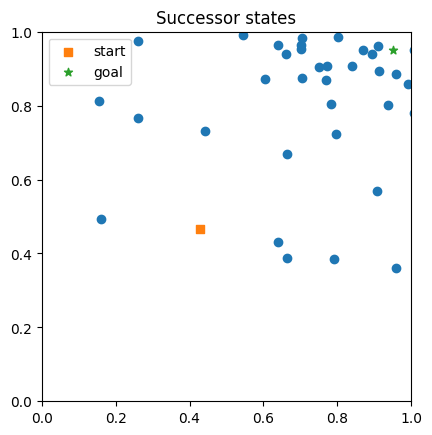

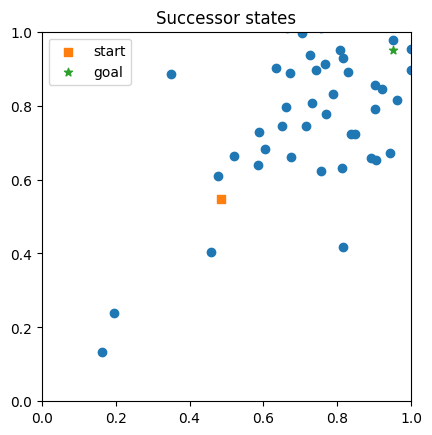

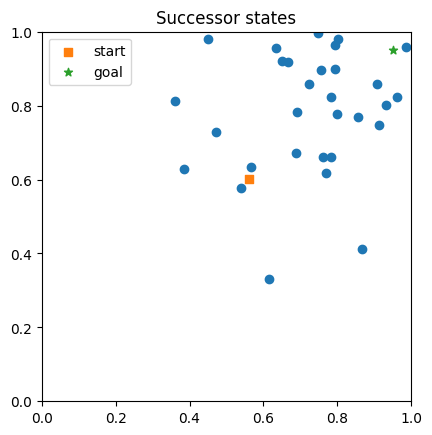

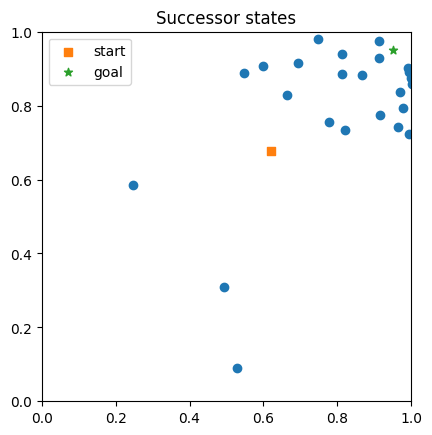

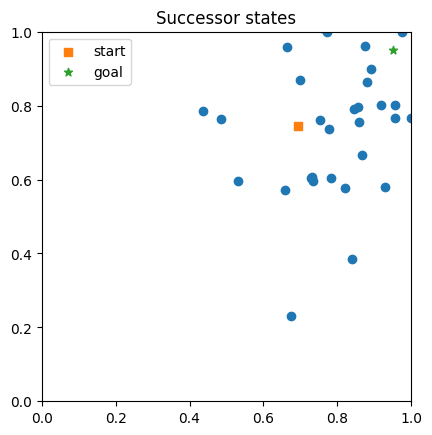

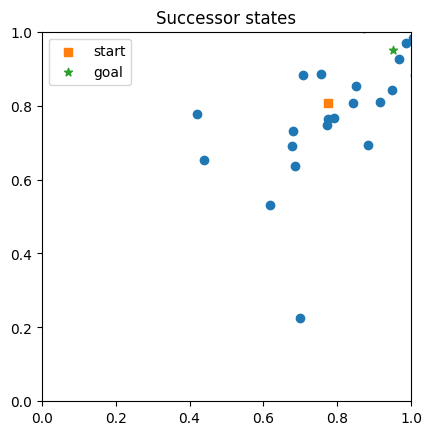

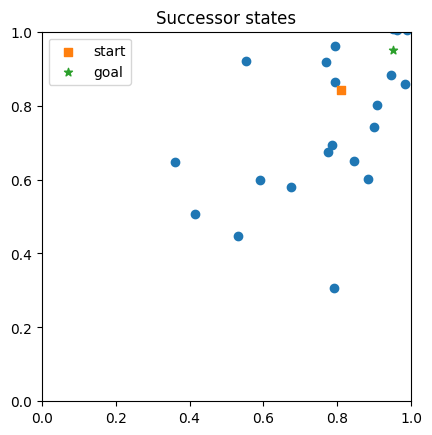

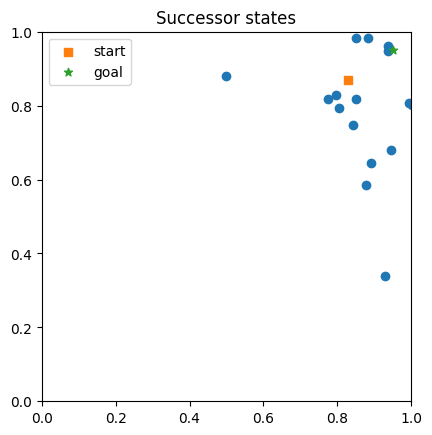

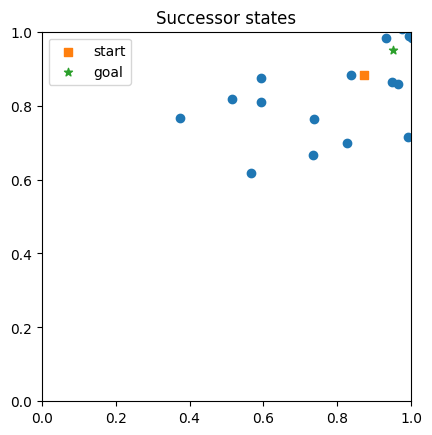

In [20]:
# Visualize the learnt flow model
NUM_INTEGRATION_STEPS = 10

def gather_flow_based_successor_states(flow_model, state, action, num_states = 100):
    
    # sample random noise from N(0, I)
    x_t = np.random.multivariate_normal(mean=np.zeros_like(state), cov = np.eye(N=np.shape(state)[0]), size=(num_states, )) # NOTE: this is x_0.
    x_t = torch.Tensor(x_t)
    time_steps = torch.linspace(0, 1.0, NUM_INTEGRATION_STEPS + 1)
    
    with torch.no_grad():
        for j in range(NUM_INTEGRATION_STEPS):
            x_t = flow_model.step(
                        x_t=x_t,
                        t_start=time_steps[j],
                        t_end=time_steps[j + 1],
                        state = torch.Tensor([state]*num_states),
                        action = torch.Tensor([action]*num_states)
                        )
    
    return x_t


for time_step in range(15):
    time_step_to_plot= time_step
    state = offline_dataset["states"][time_step_to_plot]
    action = offline_dataset["actions"][time_step_to_plot]
    flow_model_successor_states = gather_flow_based_successor_states(tdcfmc_flow_model, state, action, num_states = 100)
    plot_successor_states(env, flow_model_successor_states, state)

## TD^2-CFM

In [25]:
td2cfm_flow_model = FlowMatchingModel(state_dim=2, action_dim=2, h=64)

# Make a copy of this flow model as the target
target_flow_model = FlowMatchingModel(state_dim=2, action_dim=2, h=64)

target_flow_model.load_state_dict(td2cfm_flow_model.state_dict())

<All keys matched successfully>

In [26]:
# Train the flow matching model on offline dataset using TD-CFM
NUM_INTEGRATION_STEPS = 10

def sample_x1_td2_cfm(time, env, policy, flow_model, state, action, next_state, gamma):
    
    # Sample by integrating flow_model until step 't'
    x_t = np.random.multivariate_normal(mean=np.zeros_like(state), cov = np.eye(N=np.shape(state)[0])) # Forms the start point to integrate the noise
    x_t = torch.Tensor(x_t).view(1, -1) # BS, state_dim
    time_steps = torch.linspace(0, time, NUM_INTEGRATION_STEPS + 1) # NOTE: The time is not upto 1, it is upto time_step provided.
    
    next_action = policy.act(next_state, env.goal)
    
    with torch.no_grad():
        for j in range(NUM_INTEGRATION_STEPS):
            x_t = flow_model.step(
                        x_t=x_t,
                        t_start=time_steps[j],
                        t_end=time_steps[j + 1],
                        state = next_state.view(1, -1),
                        action = torch.Tensor([next_action])
                        )

    return np.array(next_state), np.array(x_t[0]), next_action # Return the next state as well as the bootstrapped state found by integrating till the timestep 't' and finally the next action

print(sample_x1_td2_cfm(.5, env, policy, td2cfm_flow_model, state, action, torch.Tensor(next_state), GAMMA))

(array([0.44771534, 0.42222488], dtype=float32), array([-0.49566847,  1.0144551 ], dtype=float32), array([0.6233124, 0.6599908], dtype=float32))


/tmp/ipykernel_1909048/4153933786.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(next_state), np.array(x_t[0]), next_action # Return the next state as well as the bootstrapped state found by integrating till the timestep 't' and finally the next action


In [27]:
# Training the flow model to predict x1's bootstrapped from the flow model. x_t is defined using coupling, which changes the p_t|z distribution used to sample the t'th point.

# sample t from uniform 0, 1
# sample a (state,action) from the offline data and a corresponding successor state x_1
# sample x_t from normal distribution conditioned on the z = x_1
# 

NUM_ITERATIONS = 100
BATCH_SIZE = 256
POLYAK_COEF = .1
optimizer = torch.optim.Adam(lr=1e-3, params=td2cfm_flow_model.parameters())

for train_iter in range(NUM_ITERATIONS):
    
    # Gather the indices of BATCH_SIZE
    batch_indices = np.random.choice(NUM_TRANSITIONS_TO_SAMPLE, size=(BATCH_SIZE,))
    
    # Gather the batch data
    batch_states = torch.Tensor(offline_dataset["states"][batch_indices])
    batch_actions = torch.Tensor(offline_dataset["actions"][batch_indices])
    batch_next_states = torch.Tensor(offline_dataset["next_states"][batch_indices])
    
    # clear the compute graph
    optimizer.zero_grad()
    loss = 0.0 
    
    # sample time
    t = torch.rand(size=(BATCH_SIZE, 1))
    x_0s = np.random.multivariate_normal(mean = np.zeros((2)), cov=np.eye(2), size=(BATCH_SIZE,))
    
    # sample mc successor states
    x_1s_immediate_next = []
    x_ts_immediate_next = []
    x_ts_bootstrapped = []
    x_ts = [] # The position in the flow where we want to get the vector field
    batch_next_actions = []
    for idx in range(BATCH_SIZE):
        x_1_immediate_next, x_t_bootstrapped, next_action = sample_x1_td2_cfm(t[idx][0], env, policy, td2cfm_flow_model, batch_states[idx], batch_actions[idx], batch_next_states[idx], GAMMA)
        x_1s_immediate_next.append(np.array(x_1_immediate_next))
        # Sample the corresponding x_t from the multivariate normal distribution
        x_ts_immediate_next.append(np.random.multivariate_normal(mean=t[idx][0]*x_1_immediate_next, cov=(1-t[idx][0])**2*np.eye(N=x_1_immediate_next.shape[0]))) # Sample TD-CFM like x_t's
        
        # Similarly, keep track of the other flow route
        x_ts_bootstrapped.append(np.array(x_t_bootstrapped)) # This x_t is flow model integrated until time step t
        batch_next_actions.append(next_action)
        
    x_1s_immediate_next = np.array(x_1s_immediate_next)
    x_ts_immediate_next = np.array(x_ts_immediate_next)
    x_ts_bootstrapped = np.array(x_ts_bootstrapped)
    batch_next_actions = np.array(batch_next_actions)
    
    x_1s_immediate_next = torch.Tensor(x_1s_immediate_next)
    x_ts_immediate_next = torch.Tensor(x_ts_immediate_next)
    x_ts_bootstrapped = torch.Tensor(x_ts_bootstrapped)
    batch_next_actions = torch.Tensor(batch_next_actions)
    
    # Groundtruth velocities
    u_t_x1 = (x_1s_immediate_next - x_ts_immediate_next)/(1 - t)
    
    # Target network provides the ground truth flow here
    gt_target_velocities = target_flow_model(t=t, state = batch_next_states, action = batch_next_actions, x_t = x_ts_bootstrapped)
    
    # Flow model predictions
    flow_model_velocity_immediate_next = td2cfm_flow_model(t = t, state = batch_states, action = batch_actions, x_t = x_ts_immediate_next)
    
    flow_model_velocity_bootstrapped = td2cfm_flow_model(t = t, state = batch_states, action = batch_actions, x_t = x_ts_bootstrapped)
    
    loss = (1-GAMMA)*torch.linalg.norm(u_t_x1 - flow_model_velocity_immediate_next, axis=1).pow(2).mean() + GAMMA*torch.linalg.norm(gt_target_velocities - flow_model_velocity_bootstrapped, axis=1).pow(2).mean()
    
    loss.backward()
    optimizer.step()
    print(f"Train Iter {train_iter}, Loss: {loss.item()}")
    
    # Polyak averaging
    for param, target_param in zip(td2cfm_flow_model.parameters(), target_flow_model.parameters()):
        target_param.data.mul_(POLYAK_COEF) # Original contribution
        target_param.data.add_((1-POLYAK_COEF)*param) # New addition
    

/tmp/ipykernel_1909048/4153933786.py:23: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(next_state), np.array(x_t[0]), next_action # Return the next state as well as the bootstrapped state found by integrating till the timestep 't' and finally the next action
/tmp/ipykernel_1909048/2699228033.py:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_ts_immediate_next.append(np.random.multivariate_normal(mean=t[idx][0]*x_1_immediate_next, cov=(1-t[idx][0])**2*np.eye(N=x_1_immediate_next.shape[0]))) # Sample TD-CFM like x_t's
/tmp/ipykernel_1909048/2699228033.py:41: DeprecationWarning: __array__ implementation doesn't accept a co

Train Iter 0, Loss: 0.27651071548461914
Train Iter 1, Loss: 0.2840414047241211
Train Iter 2, Loss: 0.2553451657295227
Train Iter 3, Loss: 0.2428223192691803
Train Iter 4, Loss: 0.24283458292484283
Train Iter 5, Loss: 0.2190154790878296
Train Iter 6, Loss: 0.21400851011276245
Train Iter 7, Loss: 0.19051778316497803
Train Iter 8, Loss: 0.20772641897201538
Train Iter 9, Loss: 0.20044027268886566
Train Iter 10, Loss: 0.18676188588142395
Train Iter 11, Loss: 0.19413062930107117
Train Iter 12, Loss: 0.19160807132720947
Train Iter 13, Loss: 0.17447753250598907
Train Iter 14, Loss: 0.17380037903785706
Train Iter 15, Loss: 0.16139721870422363
Train Iter 16, Loss: 0.17087742686271667
Train Iter 17, Loss: 0.14084303379058838
Train Iter 18, Loss: 0.16316768527030945
Train Iter 19, Loss: 0.12185985594987869
Train Iter 20, Loss: 0.15049117803573608
Train Iter 21, Loss: 0.14656437933444977
Train Iter 22, Loss: 0.12872685492038727
Train Iter 23, Loss: 0.14356520771980286
Train Iter 24, Loss: 0.1188884

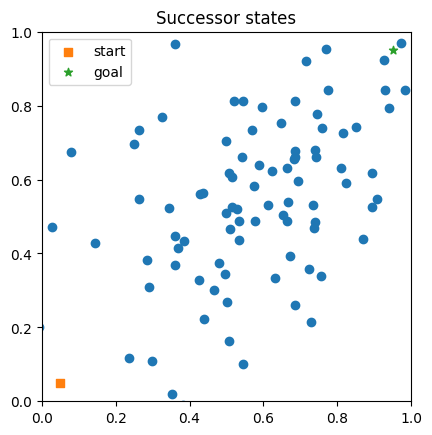

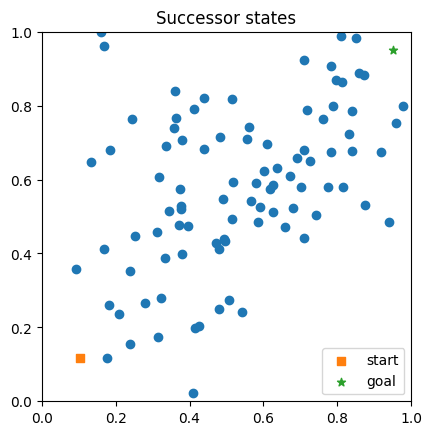

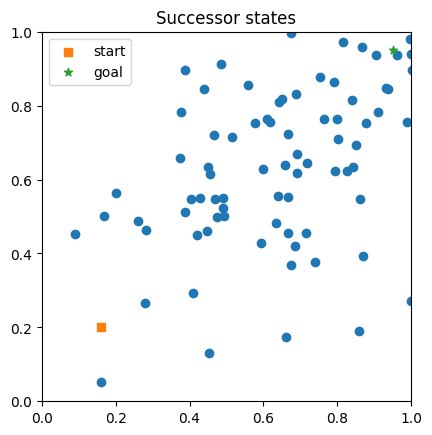

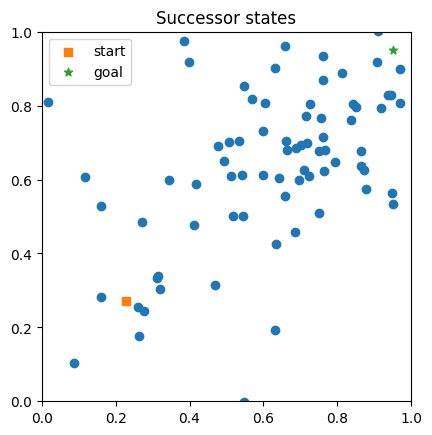

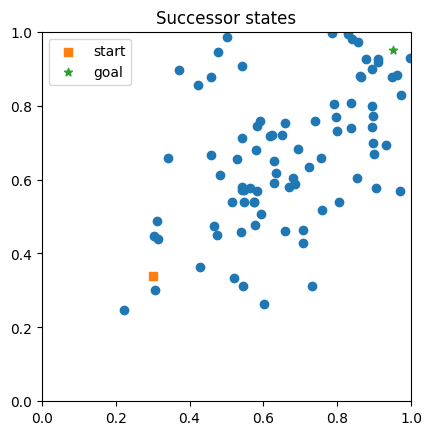

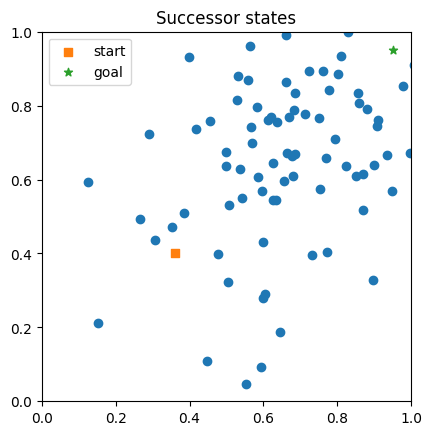

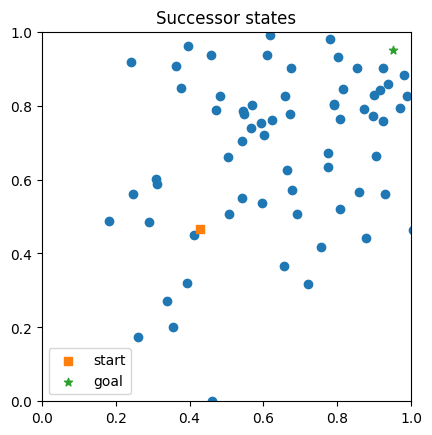

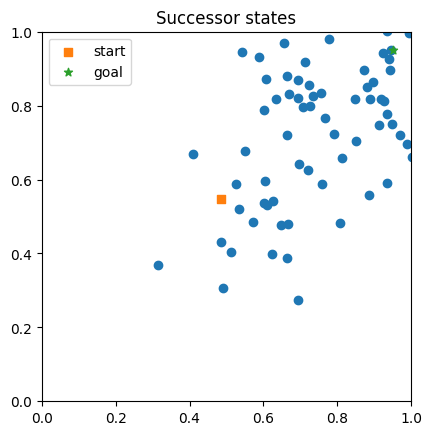

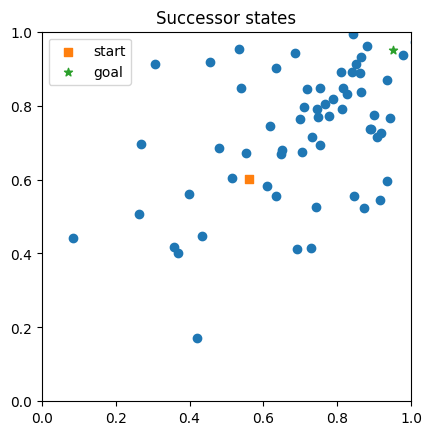

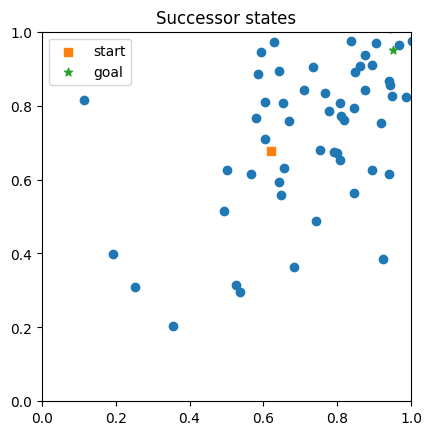

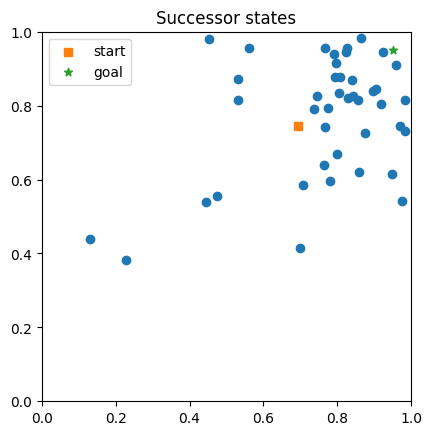

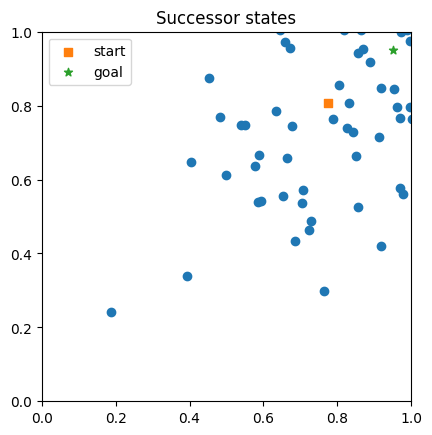

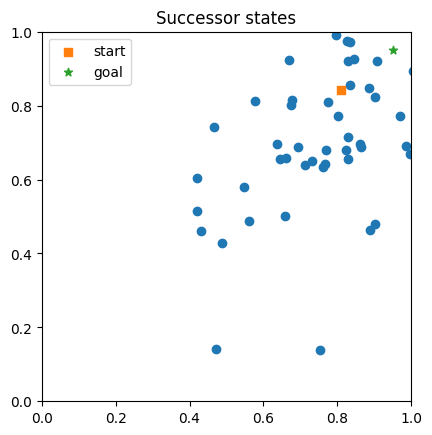

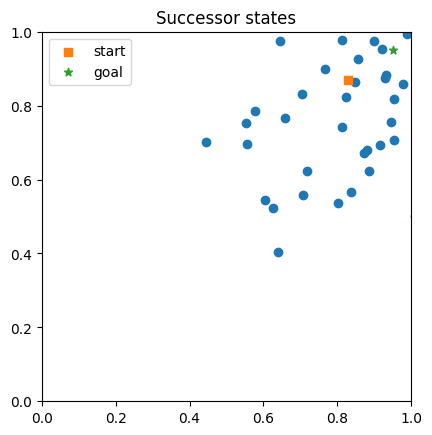

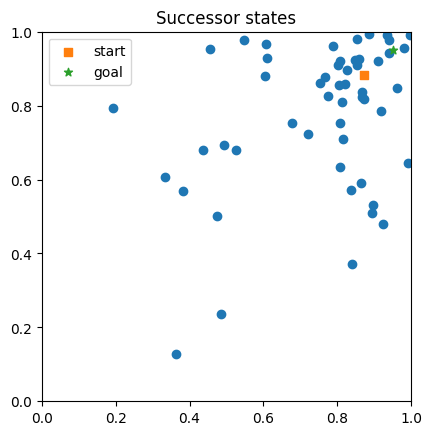

In [28]:
# Visualize the learnt flow model
NUM_INTEGRATION_STEPS = 10

def gather_flow_based_successor_states(flow_model, state, action, num_states = 100):
    
    # sample random noise from N(0, I)
    x_t = np.random.multivariate_normal(mean=np.zeros_like(state), cov = np.eye(N=np.shape(state)[0]), size=(num_states, )) # NOTE: this is x_0.
    x_t = torch.Tensor(x_t)
    time_steps = torch.linspace(0, 1.0, NUM_INTEGRATION_STEPS + 1)
    
    with torch.no_grad():
        for j in range(NUM_INTEGRATION_STEPS):
            x_t = flow_model.step(
                        x_t=x_t,
                        t_start=time_steps[j],
                        t_end=time_steps[j + 1],
                        state = torch.Tensor([state]*num_states),
                        action = torch.Tensor([action]*num_states)
                        )
    
    return x_t

for time_step in range(15):
    time_step_to_plot= time_step
    state = offline_dataset["states"][time_step_to_plot]
    action = offline_dataset["actions"][time_step_to_plot]
    flow_model_successor_states = gather_flow_based_successor_states(td2cfm_flow_model, state, action, num_states = 100)
    plot_successor_states(env, flow_model_successor_states, state)